In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore', message='.*unary_union.*')

lodes = pd.read_csv("data/LODES.csv", low_memory=False)
census = pd.read_csv("data/Decennial_Census.csv")
shapes = gpd.read_file("data/tract_shapefiles/il_t_2020_bound.shp")

lodes["workplace_tract_code"] = lodes["workplace_block_code"].apply(lambda x: str(x)[:11])
lodes["home_tract_code"] = lodes["home_block_code"].apply(lambda x: str(x)[:11])

lodes.drop("Unnamed: 0", axis=1, inplace=True)
census.drop("Unnamed: 0", axis=1, inplace=True)
shapes = shapes[['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'GEOID20', 'geometry']]
shapes = shapes.to_crs(epsg=3435)
census["tract_code"] = census["geo_id"].apply(lambda x: x[-11:])
census["population"] = census["white"] + census["black"] + census["asian"] + census["american_indian_alaska_native"] + census["pacific_islander"] + census["other_race"] + census["multiracial"] + census["hispanic_latino"]

In [ ]:
import random
from shapely.geometry import Polygon
from shapely.ops import unary_union
import networkx as nx
import numpy as np
random.seed(39)

class ILRedistricting:
    def __init__(self, census_df, shapes_df, lodes_df, n_districts=17):
        '''initializes'''
        self.census = census_df.copy()
        self.shapes = shapes_df.copy()
        self.lodes = lodes_df.copy()
        self.n_districts = n_districts

        self.data = self.census.merge(
            self.shapes[['GEOID20', 'geometry']], 
            left_on='tract_code', right_on='GEOID20', 
            how='left'
        ).drop(columns=['GEOID20'])
        
        self.data = gpd.GeoDataFrame(self.data, geometry='geometry')
        self.data.set_crs(epsg=3435, inplace=True)

        self.block_to_idx = dict(zip(self.data['tract_code'], range(len(self.data))))
        self.graph = self._create_block_graph()

    def _create_block_graph(self):
        graph = nx.Graph()
        for idx, row in self.data.iterrows():
            graph.add_node(row['tract_code'], geometry=row['geometry'])
            #adds a node for every tract
        
        for idx, row in self.data.iterrows():
            possible_neighbors = self.data.sindex.query(row['geometry'], predicate='intersects')
            for neighbor_idx in possible_neighbors:
                if idx != neighbor_idx:
                    neighbor_geom = self.data.iloc[neighbor_idx]['geometry']
                    if row['geometry'].intersection(neighbor_geom).length > 0:
                        graph.add_edge(row['tract_code'], self.data.iloc[neighbor_idx]['tract_code'])
                        #adds edges connecting all adjacent tracts, with nodes being each individual tract
        return graph


    def calculate_compactness(self, district_geometries):
        '''Polsby-Popper Score'''
        scores = []
        for geometry in district_geometries:
            area = geometry.area
            perimeter = geometry.length
            scores.append(4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0)
            #uses polsby popper compactness score
        return np.mean(scores)

    def calculate_community_preservation(self, districts):
        '''Uses LODES data to calculate a score approximating the preservation of employment-living relationships across tracts'''
        scores = []
        for district in districts:
            tracts = district
            filtered_df = self.lodes[(self.lodes['workplace_tract_code'].isin(tracts)) | (self.lodes['home_tract_code'].isin(tracts))]

            total_live_in_tracts = filtered_df[filtered_df['home_tract_code'].isin(tracts)]['total_jobs'].sum()
            total_work_in_tracts = filtered_df[filtered_df['workplace_tract_code'].isin(tracts)]['total_jobs'].sum()

            live_and_work_in_tracts = filtered_df[
                (filtered_df['workplace_tract_code'].isin(tracts)) &
                (filtered_df['home_tract_code'].isin(tracts))
            ]['total_jobs'].sum()

            percentage_live_and_work = (live_and_work_in_tracts / total_live_in_tracts) * 100 if total_live_in_tracts > 0 else 0
            percentage_work_and_live = (live_and_work_in_tracts / total_work_in_tracts) * 100 if total_work_in_tracts > 0 else 0
            district_score = (2/3 * percentage_live_and_work) + (1/3 * percentage_work_and_live) #didn't weight them equally as there are lots of tracts whose employees come from all over (particularly downtown/city center tracts), leading to spindly commuter districts. 
            #instead, both conceptually and for logisical ease, it matters more that the people who live in an area also happen to work there than the other way around. will be further discussed in the methodology section 
            scores.append(district_score)

        return np.mean(scores)

    def mcmc(self, iterations=10000):
        """
        Run the Monte Carlo Markov Chain process.
        """
        districts = self._initialize_random_districts()
        districtsinitial = districts
        best_districts = None
        best_score = float('-inf')

        for iteration in range(iterations):
            new_districts = self._propose_new_districts(districts)

            score = self.evaluate(new_districts)
            meets_criteria = self._is_valid_districting(new_districts)
            print(f"Iteration {iteration}: Score={score:.4f}, Meets criteria={meets_criteria}")

            if meets_criteria and score > best_score:
                best_districts = new_districts
                best_score = score

            if score > self.evaluate(districts) or random.uniform(0, 1) < np.exp(score - self.evaluate(districts)): #metropolis-hastings update
                districts = new_districts

        return best_districts, districtsinitial

    def _initialize_random_districts(self):
        """
        Generate initial districts that are guaranteed to be contiguous using a flood-fill approach.
        Restart if contiguity is violated.
        """
        while True:
            total_population = self.data['population'].sum()
            target_population = total_population / self.n_districts

            unassigned_blocks = set(self.data['tract_code'])
            block_populations = dict(zip(self.data['tract_code'], self.data['population']))
            districts = [[] for _ in range(self.n_districts)]
            district_populations = [0] * self.n_districts

            for district_idx in range(self.n_districts):
                if not unassigned_blocks:
                    break

                seed_block = random.choice(list(unassigned_blocks))
                queue = [seed_block]

                while queue:
                    block = queue.pop(0)

                    if block not in unassigned_blocks:
                        continue
                    if district_populations[district_idx] + block_populations[block] > target_population * 1.1:
                        continue

                    districts[district_idx].append(block)
                    district_populations[district_idx] += block_populations[block]
                    unassigned_blocks.remove(block)

                    neighbors = list(self.graph.neighbors(block))
                    for neighbor in neighbors:
                        if neighbor in unassigned_blocks:
                            queue.append(neighbor)

            for block in unassigned_blocks:
                best_district = None
                max_neighbors = -1

                neighbors = list(self.graph.neighbors(block))
                for district_idx, district in enumerate(districts):
                    neighbor_count = sum(1 for neighbor in neighbors if neighbor in district)
                    if neighbor_count > max_neighbors:
                        max_neighbors = neighbor_count
                        best_district = district_idx

                if best_district is not None:
                    districts[best_district].append(block)
                    district_populations[best_district] += block_populations[block]
                else:
                    #worst case fallback to force issue
                    min_population_idx = district_populations.index(min(district_populations))
                    districts[min_population_idx].append(block)
                    district_populations[min_population_idx] += block_populations[block]
            
            #ensure no districts are left empty 
            for idx, district in enumerate(districts):
                if not district:
                    print(f"District {idx} was empty during initialization. Redistributing.")
                    seed_block = unassigned_blocks.pop()
                    districts[idx].append(seed_block)

            if self._validate_contiguity(districts):
                return districts
            else:
                print("Violation: Initial districts are not contiguous. Restarting generation...")




    def _propose_new_districts(self, districts):
        """
        Propose new districts by swapping contiguous subdistricts of tracts.
        Restart if contiguity is violated.
        """
        while True:
            new_districts = [list(district) for district in districts]

            from_district_idx = random.randint(0, len(new_districts) - 1)
            from_district = new_districts[from_district_idx]

            if not from_district:
                continue

            seed_tract = random.choice(from_district)
            queue = [seed_tract]
            visited = set()
            subdistrict = []

            while queue and len(subdistrict) < max(1, len(from_district) // 10):
                tract = queue.pop(0)
                if tract in visited or tract not in from_district:
                    continue
                visited.add(tract)
                subdistrict.append(tract)
                neighbors = list(self.graph.neighbors(tract))
                queue.extend(neighbors)

            neighboring_districts = {
                neighbor: idx
                for tract in subdistrict
                for neighbor in self.graph.neighbors(tract)
                for idx, district in enumerate(new_districts)
                if neighbor in district and idx != from_district_idx
            }

            if not neighboring_districts:
                continue

            to_district_idx = random.choice(list(neighboring_districts.values()))
            to_district = new_districts[to_district_idx]

            for tract in subdistrict:
                from_district.remove(tract)
                to_district.append(tract)

            #to ensure no district is empty, as that throws off the entire algorithm/chain
            for idx, district in enumerate(new_districts):
                if not district:
                    print(f"District {idx} became empty. Redistributing its tracts.")
                    neighbors = [neighbor for tract in districts[idx] for neighbor in self.graph.neighbors(tract)]
                    for neighbor in neighbors:
                        for other_idx, other_district in enumerate(new_districts):
                            if neighbor in other_district:
                                new_districts[other_idx].extend(district)
                                break
                    new_districts[idx] = []

            if self._validate_contiguity(new_districts):
                return new_districts
            else:
                print("Violation: Proposed districts are not contiguous. Restarting proposal...")
    
    def _is_valid_districting(self, districts):
        """
        Validate that all districts are contiguous. This is the only hard criterion.
        """
        for district in districts:
            subgraph = self.graph.subgraph(district)
            if not nx.is_connected(subgraph):
                return False
        return True

    def evaluate(self, districts):
        """
        Evaluate the quality of a districting map based on compactness, community preservation,
        VRA compliance, and population parity.
        """
        district_geometries = [
            unary_union([self.graph.nodes[tract]['geometry'] for tract in district]) for district in districts
        ]

        compactness = self.calculate_compactness(district_geometries)
        community_preservation = self.calculate_community_preservation(districts)/100

        target_population = self.data['population'].sum() / self.n_districts
        district_populations = [
            sum(self.data[self.data['tract_code'].isin(district)]['population']) for district in districts
        ]

        pop_parity_score = 0
        for pop in district_populations:
            deviation = abs(pop - target_population) / target_population
            if deviation <= 0.1:  
                pop_parity_score += 1 - deviation  
            else:
                pop_parity_score += -10 * ((deviation - 0.1) ** 3)

        pop_parity_score /= len(districts)

        hispanic_majority = sum(
            1 for district in districts if sum(
                self.data[self.data['tract_code'].isin(district)]['hispanic_latino']) >
                sum(self.data[self.data['tract_code'].isin(district)]['population']) / 2
        )
        black_majority = sum(
            1 for district in districts if sum(
                self.data[self.data['tract_code'].isin(district)]['black']) >
                sum(self.data[self.data['tract_code'].isin(district)]['population']) / 2
        )

        vra_score = 5  
        hispanic_shortfall = max(0, 2 - hispanic_majority)
        black_shortfall = max(0, 2 - black_majority)
        vra_score -= 2 * (hispanic_shortfall + black_shortfall)

        total_score = (compactness + community_preservation + pop_parity_score + vra_score)
        print(f"Compactness: {compactness:.4f}, Community Preservation: {community_preservation:.4f}, "
            f"Population Parity: {pop_parity_score:.4f}, VRA Score: {vra_score:.4f}, "
            f"Total Score: {total_score:.4f}")

        return total_score
    
    def _validate_contiguity(self, districts):
        for district_idx, district in enumerate(districts):
            if not district:
                print(f"District {district_idx} is empty!")
                return False
            subgraph = self.graph.subgraph(district)
            if not nx.is_connected(subgraph):
                print(f"District {district_idx} is not contiguous.")
                return False
        return True



Starting to apply the process:

In [ ]:
import cProfile
import pstats
import io

def profile_mcmc(il_redistricting, iterations=10):
    pr = cProfile.Profile()
    pr.enable()

    optimal_districts, districtsinitial = il_redistricting.mcmc(iterations=iterations)

    pr.disable()
    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
    ps.print_stats(20)  
    print(s.getvalue())
    return optimal_districts

In [ ]:
il_redistricting = ILRedistricting(census, shapes, lodes, n_districts=17)

In [13]:
optimal_districts, districtsinitial = il_redistricting.mcmc(iterations=10)

Compactness: 0.2116, Community Preservation: 0.4287, Population Parity: 0.0883, VRA Score: -3.0000, Total Score: -2.2714
Compactness: 0.2116, Community Preservation: 0.4287, Population Parity: 0.0883, VRA Score: -3.0000, Total Score: -2.2714
District 16 is not contiguous.
Violation: Proposed districts are not contiguous. Restarting proposal...
Compactness: 0.2054, Community Preservation: 0.4262, Population Parity: 0.0374, VRA Score: -3.0000, Total Score: -2.3311
Iteration 7: Score=-2.3311, Meets criteria=True
Compactness: 0.2062, Community Preservation: 0.4270, Population Parity: 0.0874, VRA Score: -3.0000, Total Score: -2.2794
Compactness: 0.2062, Community Preservation: 0.4270, Population Parity: 0.0874, VRA Score: -3.0000, Total Score: -2.2794
Compactness: 0.1999, Community Preservation: 0.4260, Population Parity: -0.0174, VRA Score: -3.0000, Total Score: -2.3916
Iteration 8: Score=-2.3916, Meets criteria=True
Compactness: 0.2054, Community Preservation: 0.4262, Population Parity: 0

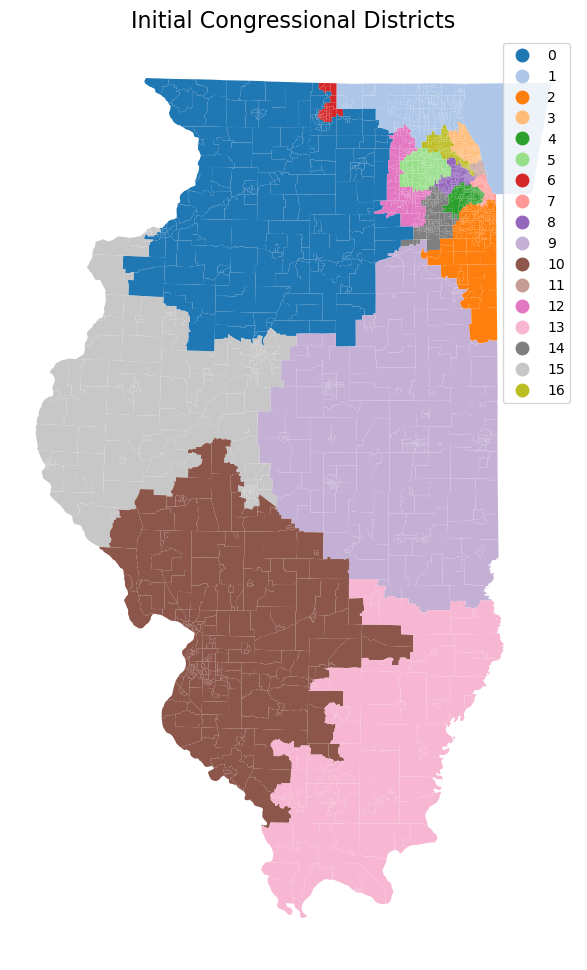

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

il_redistricting.data['district'] = -1  
for district_number, district in enumerate(districtsinitial):
    il_redistricting.data.loc[
        il_redistricting.data['tract_code'].isin(district), 'district'
    ] = district_number

cmap = mcolors.ListedColormap(plt.cm.tab20.colors[:17])

fig, ax = plt.subplots(figsize=(12, 12))
il_redistricting.data.plot(
    column='district', 
    cmap=cmap, 
    legend=True, 
    categorical=True, 
    ax=ax
)

ax.set_title("Initial Congressional Districts", fontsize=16)
ax.set_axis_off()

plt.show()


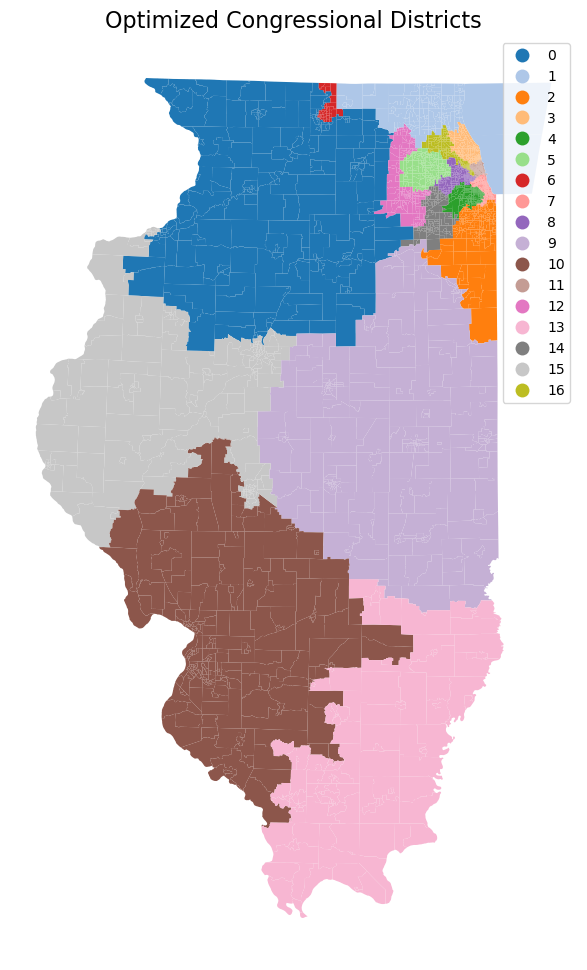

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

il_redistricting.data['district'] = -1  
for district_number, district in enumerate(optimal_districts):
    il_redistricting.data.loc[
        il_redistricting.data['tract_code'].isin(district), 'district'
    ] = district_number

cmap = mcolors.ListedColormap(plt.cm.tab20.colors[:17])

fig, ax = plt.subplots(figsize=(12, 12))
il_redistricting.data.plot(
    column='district', 
    cmap=cmap, 
    legend=True, 
    categorical=True, 
    ax=ax
)

ax.set_title("Optimized Congressional Districts", fontsize=16)
ax.set_axis_off()

plt.show()


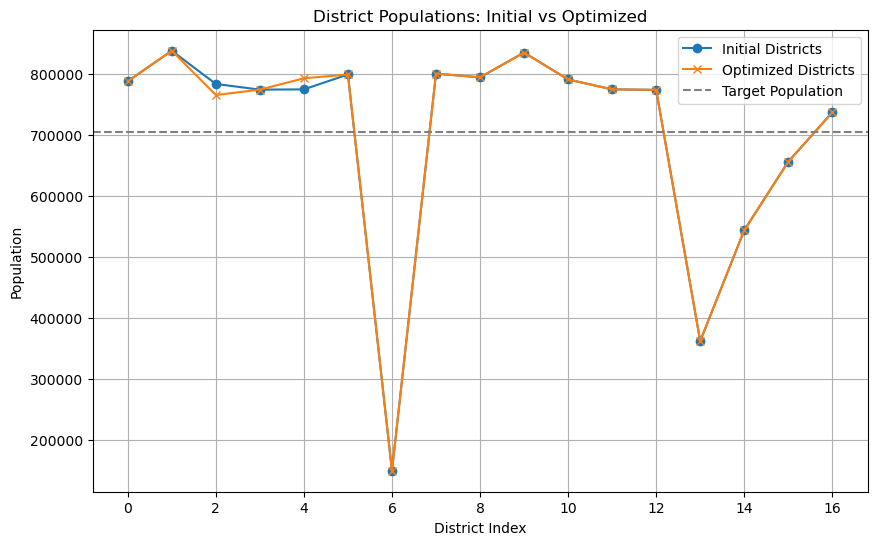

In [ ]:
import matplotlib.pyplot as plt

def calculate_district_populations(districts, data):
    return [
        sum(data[data['tract_code'].isin(district)]['population'])
        for district in districts
    ]

initial_populations = calculate_district_populations(districtsinitial, il_redistricting.data)
optimized_populations = calculate_district_populations(optimal_districts, il_redistricting.data)

plt.figure(figsize=(10, 6))
plt.plot(initial_populations, label="Initial Districts", marker='o')
plt.plot(optimized_populations, label="Optimized Districts", marker='x')
plt.axhline(
    il_redistricting.data['population'].sum() / il_redistricting.n_districts,
    color='gray', linestyle='--', label="Target Population"
)

plt.title("District Populations: Initial vs Optimized")
plt.xlabel("District Index")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.show()
